Install all necessary packages

In [0]:
!pip install ripser

Import packages and check gpu availability

In [0]:
# import PyTorch modules
import torch
import torch.nn as nn
import torch.cuda as cuda
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, WeightedRandomSampler, BatchSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder
# make sure that we only run with GPU hardware acceleration
assert cuda.is_available()

# import relevant image processing modules and functions
from PIL import Image
import imageio
import cv2
from google.colab.patches import cv2_imshow

# import scientific computing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from ripser import ripser
from persim import plot_diagrams
import math

# import standard Python libraries
import random
import time
import os
import shutil
from shutil import copyfile
from collections import deque
from glob import glob
import pickle

Define funtions for generating toy data set, persistent homology vectors, and labels


In [0]:
# data-generation functions

def generate_data(filename):
    img = np.zeros((200,200,3), np.uint8)
    num_circles = random.randint(2, 5)
    for i in range(num_circles):
        center = random.randint(40, 160), random.randint(40, 160)
        radius = random.randint(10, 40)
        width = random.randint(1, 5)
        img = cv2.circle(img,center, radius, (255,255,255), width)
    imageio.imwrite(filename, img)
    return img

# global variable to for exploratory analysis
component_sizes = []

# label generating function
def count_holes(img, threshold=5):
    def flood_fill(x, y, binary_np, label):
        counter = 0
        q = deque([(x, y)])
        while len(q) > 0:
            n_x, n_y = q.popleft()
            if 0 <= n_x < binary_np.shape[0] and 0 <= n_y < binary_np.shape[1]:
                if binary_np[n_x][n_y] == 0:
                    counter += 1
                    neighbors = [(n_x-1, n_y), (n_x+1, n_y),
                                    (n_x, n_y-1), (n_x, n_y+1)]
                    for neighbor in neighbors:
                        q.append(neighbor)
                    binary_np[n_x][n_y] = label + 1
        return counter
    img = np.array(img)
    binary_np = np.zeros((img.shape[0], img.shape[1]), dtype=int)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if sum(img[x][y]) > 50:
                binary_np[x][y] = 1
    label = 0
    num_valid_components = 0
    for x in range(binary_np.shape[0]):
        for y in range(binary_np.shape[1]):
            if binary_np[x][y] == 0:
                label += 1
                component_size = flood_fill(x, y, binary_np, label)
                component_sizes.append(component_size)
                if component_size > threshold:
                    num_valid_components += 1
    return num_valid_components - 1

def generate_point_cloud(filename, threshold = 0.005, plot = False):
    # threshold is the probability that white pixel is converted to a point
    image = cv2.imread(filename)
    x_points, y_points, points = [], [], []
    for i in range(900):
        for j in range(900):
            if image[i][j][0]==0:
                rand = np.random.random()
                if rand<threshold:
                    x_points.append(i)
                    y_points.append(j)
                    points.append(np.array([i, j]))
    if plot:
        plt.scatter(x_points, y_points, marker = '+')
        plt.show()
    
    return np.array(points).reshape(len(points), 2)

def generate_data_from_file(file_name, dimension):
    point_cloud = generate_point_cloud(file_name, plot = False)
    diagrams = ripser(point_cloud)['dgms']
    H0_points, H1_points = diagrams
    diff = lambda x: x[1]-x[0]
    H1_diffs = torch.Tensor([diff(point) for point in H1_points])  
    adj_dimension = min(dimension, len(H1_diffs))
    top_H1_diffs, indices = H1_diffs.topk(adj_dimension)
    
    return top_H1_diffs


Generate data set of images, persitent homology vectors, and labels from toy data.

In [0]:
# create directories
if os.path.exists("data_raw"):
    shutil.rmtree("data_raw")
os.mkdir("data_raw")

# generate data
num_samples = 10000
for i in range(num_samples):
    generate_data('data_raw/' + str(i).zfill(4) + ".png")
    if i % 50 == 0:
        print("Generated {} samples".format(str(i).zfill(4)))

In [0]:
# generate persistent homology vectos
topology_data = []
files = sorted(glob('data_raw/[0-9][0-9][0-9][0-9].png'))
for file in files:
    topology_data.append(enerate_data_from_file(file, 20))

In [0]:
# generate labels
labels = []
for i in range(num_samples):
    image = np.array(Image.open('data/' + str(i).zfill(4) + ".png"))
    label = count_holes(image, threshold=5)
    labels.append(label)
    if i % 10 == 0:
        print("Labeled {} samples".format(str(i).zfill(4)))

Turn data into zip files so that we can store the data locally rather than have to generate it each time

In [0]:
!zip -r /content/data_raw.zip /content/data_raw

Alternatively, if we are returning to this notebook after having already generated the data, then we may just want to load in the data rather than create new data.
Here, unzip our data and remove previous existing folders if needed.
Before running the next cell, make sure that you have added `data_raw.zip` to the `contents` folder of the colab environment.

In [0]:
if os.path.exists("data_raw"):
    shutil.rmtree("data_raw")
!unzip data_raw.zip -d ../content/data_raw/

Save or Load `labels.pkl` and `topology_data.pkl`.

In [0]:
# Save the persistent homolgy vector as .pkl
with open('topology_data.pkl', 'wb') as file:
    pickle.dump(topology_data, file)

In [0]:
# Save labels as .pkl
with open('labels.pkl', 'wb') as file:
    pickle.dump(labels, file)

In [0]:
# Load topology data from .pkl as list
with open('topology_data.pkl', 'rb') as file:
    topology_data = pickle.load(file)

# pad the vector with 0's
processed_top_data = []
for index, top_vector in topology_data:
    padded = np.zeros(20, dtype=np.float32)
    padded[:len(top_vector)] = top_vector
    processed_top_data.append(padded)

In [0]:
# Load labels from .pkl as list
with open('labels.pkl', 'rb') as file:
    labels = pickle.load(file)

Toy Dataset
 *   Images from our toy data set + cropped labels
 *   Topological data extracted the images using persistent homology + cropped labels
 *   Combining both into a single data set + cropped labels


In [0]:
MAX_HOLES = 10

class ImageData(Dataset):
    def __init__(self, image_file_locations, labels):
        self.image_file_locations = image_file_locations
        self.images = [Image.open(file) for file in image_file_locations]
        self.images = [image.resize((200, 200)) for image in self.images]
        self.image_np_arrays = [np.array(image, dtype=np.float32).transpose((2,0,1)) for image in self.images]
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.image_np_arrays[idx], self.labels[idx]

class TopologicalData(Dataset):
    def __init__(self, topology_data, labels):
        self.topology_data = topology_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.topology_data[idx], self.labels[idx]

class ImageAndTopologicalData(Dataset):
    def __init__(self, image_file_locations, topology_data, labels):
        self.image_file_locations = image_file_locations
        self.images = [Image.open(file) for file in image_file_locations]
        self.images = [image.resize((200, 200)) for image in self.images]
        self.image_np_arrays = [np.array(image, dtype=np.float32).transpose((2,0,1)) for image in self.images]
        self.topology_data = topology_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.image_np_arrays[idx], self.topology_data[idx]), self.labels[idx]

In [0]:
# Toy Datasets
files = sorted(glob('data_raw/[0-9][0-9][0-9][0-9].png'))
cropped_labels = [max(min(MAX_HOLES + 1, i), 2) - 2 for i in labels]
image_data = ImageData(files, cropped_labels)
topological_data = TopologicalData(processed_top_data, cropped_labels)
image_and_topological_data = ImageAndTopologicalData(files, processed_top_data, cropped_labels)


Define the functions that we will use to initialize the DataLoader's that we will use for our experiments. Make sure that the data sets have been initialized in the previous cell.

In [0]:
bs = 64 # may need to be adjusted depending on GPU size

def get_stratified_sampler(data):
    labels = [label for _, label in data]
    frequencies = np.bincount(labels)
    weights = [1/frequencies[label] for label in labels]
    return WeightedRandomSampler(weights, len(weights), replacement=True)

def get_data_loaders(data, split=(7000, 1000, 2000)):
    train, validation, test = torch.utils.data.random_split(data, split)
    train_loader = DataLoader(train, sampler=get_stratified_sampler(train), batch_size=bs)
    validation_loader = DataLoader(validation, sampler=get_stratified_sampler(validation), batch_size=bs)
    test_loader = DataLoader(test, sampler=get_stratified_sampler(test), batch_size=bs)
    return train_loader, validation_loader, test_loader


Define the Neural Network structures that we will use for our experiments.
These include

*   Vanilla Convolutional Neural Network
*   Convolutional Neural Network with OrdinalRegression Layer with pre-determined thresholds
*   Convolutional Neural Network with OrdinalRegression Layer with trainable thresholds
*   Sparse single-layer network with sigmoid activation (for inputting homological data)



In [0]:
# baseline model, one-layer convnet
class ConvNet(torch.nn.Module):

    # batch shape for input x is (bs, img_size, img_size)
    
    def __init__(self, conv_dropout=0.0, fc_dropout=0.0, num_labels=11):
        super(ConvNet, self).__init__()
        self.conv_block = ConvBlock(output_size=num_labels)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, inference=False):
        x = self.conv_block(x)

        # We handle training and inference separately, see documentation for CrossEntropyLoss
        # https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss
        if inference:
            x = self.softmax(x)
            return x
        else:
            return x

class ConvBlock(nn.Module):
    def __init__(self, conv_dropout=0.0, fc_dropout=0.0, output_size=10):
        super(ConvBlock, self).__init__()
                
        self.conv = nn.Conv2d(3, 1, kernel_size=2, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=2, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(1, 1, kernel_size=2, stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(576, 100)
        self.fc2 = nn.Linear(100, output_size)

    def forward(self, x, inference=False):
        
        # Computes activation of the first convolution
        # Size changes from (bs, img_size, img_size) to (cnn_output, img_size, img_size)
        x = F.relu(self.conv(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
class OrdinalRegressionLayer(nn.Module):
    """
    Expected input shape: (batch_size, 1)
    Expected output shape: (batch_size, num_labels)

    Assume that we are running on cuda
    """
    def __init__(self, num_labels=10, trainable=False):
        self.num_labels = num_labels
        super(OrdinalRegressionLayer, self).__init__()
        self.register_buffer("partition", torch.zeros(num_labels + 1))
        cutoffs = nn.Parameter(torch.Tensor(np.linspace(start=0, stop=10, num=self.num_labels - 1)))
        self.register_parameter("cutoffs", cutoffs)
        self.cutoffs.requires_grad = trainable
        self.partition[1: -1] = self.cutoffs
        self.partition[0] = -float("inf")
        self.partition[-1] = float("inf")
        self.register_buffer("left_tensor", self.partition[:-1])
        self.register_buffer("right_tensor", self.partition[1:])

        
    def forward(self, x):
        # array broadcasting handles adding tensors of shape (batch_size, num_labels) and (batch_size, 1)
        prob1 = torch.sigmoid(self.right_tensor - x)
        prob2 = torch.sigmoid(self.left_tensor - x)
        return prob1 - prob2
    
    def extra_repr(self):
        return 'outputs={}'.format(self.num_labels)

# baseline model, one-layer convnet
class OrdinalConvNet(nn.Module):
    # batch shape for input x is (bs, img_size, img_size)
    def __init__(self, conv_dropout=0.0, fc_dropout=0.0, num_labels=10, trainable_ordinal_thresholds=False):
        super(OrdinalConvNet, self).__init__()
        self.conv_block = ConvBlock(output_size=num_labels)
        self.fc = nn.Linear(num_labels, 1)
        self.ordinal_regression = OrdinalRegressionLayer(num_labels=num_labels, trainable=trainable_ordinal_thresholds)
        
    def forward(self, x, inference=False):
        
        # Computes activation of the first convolution
        # Size changes from (bs, img_size, img_size) to (cnn_output, img_size, img_size)
        x = self.conv_block(x)
        x = self.fc(x)
        x = self.ordinal_regression(x)
        # We handle training and inference separately because NLLLoss expects log-probabilities, see documentation
        # https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss
        if inference:
            return x
        else:
            x = torch.log(x)
            return x

In [0]:
class SparseLinear(nn.Module):
    def __init__(self, input_size, single_scaling=True):
        self.input_size = input_size
        super(SparseLinear, self).__init__()
        weights = nn.Parameter(torch.Tensor(1 if single_scaling else self.input_size).float())
        self.register_parameter("weights", weights)
        self.register_parameter("bias", nn.Parameter(torch.Tensor(1).float()))
        nn.init.normal_(self.weights.data, 1, 1/self.input_size)
        nn.init.normal_(self.bias.data, 0, 1)
    def forward(self, x):
        return x * self.weights + self.bias
    
    def extra_repr(self):
        return 'features={}'.format(self.input_size)
        

class OrdinalTopNet(torch.nn.Module):
    def __init__(self, num_labels=10, trainable_ordinal_thresholds=False):
        super(OrdinalTopNet, self).__init__()
        self.sparse_linear = SparseLinear(input_size=20)
        self.fc = nn.Linear(20, 1)
        nn.init.normal_(self.fc.weight.data, mean=0.5, std=1/20)
        self.ordinal_regression = OrdinalRegressionLayer(num_labels=num_labels, trainable=trainable_ordinal_thresholds)

    def forward(self, x, inference=False):
        # Use broadcasting to multiply Tensors of size (batch_size, 20) and (20,)
        x = torch.sigmoid(self.sparse_linear(x))
        x = self.fc(x)
        x = self.ordinal_regression(x)
        # We handle training and inference separately because NLLLoss expects log-probabilities, see documentation
        # https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss
        if inference:
            return x
        else:
            x = torch.log(x)
            return x
    def extr_reptr(self):
        return 'num_labels={}'.format(num_labels)

In [0]:
class TopConvNet(nn.Module):
    # batch shape for input x is (bs, img_size, img_size)
    def __init__(self, conv_output_size=1, output_size=10, add_softmax=False):
        super(TopConvNet, self).__init__()
        self.conv_block = ConvBlock(output_size=conv_output_size)
        self.sparse_linear = SparseLinear(20)
        self.fcc = nn.Linear(conv_output_size + 20, output_size)
        self.add_softmax = add_softmax
        if self.add_softmax:
            self.softmax = nn.Softmax(dim=1)
       
    def forward(self, inputs):
        x, y = inputs
        x = self.conv_block(x)
        
        y = torch.sigmoid(self.sparse_linear(y))

        z = torch.cat([x, y], dim=1)
        z = self.fcc(z)
        if self.add_softmax:
            z = self.softmax(z)
        return z

class OrdinalTopConvNet(nn.Module):
    def __init__(self, num_labels=10, trainable_ordinal_thresholds=False):
        super(OrdinalTopConvNet, self).__init__()
        self.top_conv_net = TopConvNet(conv_output_size=num_labels, output_size=num_labels)
        self.ordinal_regression = OrdinalRegressionLayer(num_labels=num_labels)
    def forward(self, inputs, inference=False):
        z = self.top_conv_net(inputs)
        z = self.ordinal_regression(z)
        if inference:
            return z
        else:
            z = torch.log(z)
            return z

Define the training and evaluation functions. Also define the plots.

In [0]:
def train(model, optimizer, criterion, num_epochs, train_loader, validation_loader, save_model, cuda=True, report_every=10):
    start = time.time()
    if cuda:
        model = model.cuda()
    losses = {'validation': [], 'train': []}
    best_validation_loss = float("inf")
    data_loaders = {'validation': validation_loader, 'train': train_loader}
    try:
        for epoch in range(num_epochs):
            for phase in ['validation', 'train']:
                if phase == 'train':
                    model.train(True)
                else:
                    model.train(False)
                epoch_loss = 0
                batch_counter = 0
                for inputs, labels in data_loaders[phase]:
                    if cuda:
                        labels = labels.cuda()
                        if type(inputs) == list:
                            inputs = [inpt.cuda() for inpt in inputs]
                        else:
                            inputs = inputs.cuda()
                    output = model(inputs)
                    loss = criterion(output, labels)
                    optimizer.zero_grad()
                    if phase == 'train':
                        loss.backward(retain_graph=True)
                        optimizer.step()
                    # calculate epoch loss through running total
                    epoch_loss += loss.item()
                    batch_counter += 1
                losses[phase].append(epoch_loss / batch_counter)
                if phase == 'validation':
                    if losses[phase][-1] < best_validation_loss:
                        best_validation_loss = losses[phase][-1]
                        torch.save(model.state_dict(), save_model)
                if (epoch + 1)% report_every == 0:
                    print("Epoch: " + str(epoch + 1) + "," + " {} loss: ".format(phase) + str(losses[phase][-1]))
                    if phase == "train":
                        print("Time elapsed: {} seconds".format('%.3f'%(time.time() - start)))
    except KeyboardInterrupt:
        print("You have stopped the training early.")
    print("Best validation loss: {}".format(best_validation_loss))
    return losses


def evaluate(model, best_model_file, test_loader, criterion):
    model.eval()
    model.cuda()
    for model_version in ['final', 'best']:
        test_labels = []
        test_preds = []
        test_loss = 0
        if model_version == 'best':
            model.load_state_dict(torch.load(best_model_file))
        with torch.no_grad():
            test_points_counter = 0
            for inputs, labels in test_loader:
                test_labels += list(labels)
                if type(inputs) == list:
                    inputs = [inpt.cuda() for inpt in inputs]
                else:
                    inputs = inputs.cuda()
                labels = torch.LongTensor([int(label) for label in labels]).cuda()
                output = model(inputs)
                loss = criterion(output, labels)
                test_loss += loss.item() # divide by normalizing constant
                preds = output.argmax(dim=1) # check this, want to find largest probability from softmax layer
                test_preds += list(preds)
                test_points_counter += 1
        accuracy = sum(np.asarray(test_labels) == np.asarray(test_preds)) / len(test_labels)
        print("Test Loss: {} on {} model".format(str(test_loss / test_points_counter), model_version))
        print("Accuracy: {} on {} model".format(str(accuracy), model_version))


def plot(losses, title, length=25):
    plt.figure(title)
    plt.plot([i for i in range(1, length + 1)], losses["train"][:length], label="Training Loss")
    plt.plot([i for i in range(1, length + 1)], losses["validation"][:length], label="Validation Loss")
    plt.ylabel("Negative Log-Likelihood")
    plt.xlabel("Epochs")
    plt.title(title)
    plt.legend()
    plt.show()



Initialize DataLoader's

In [0]:
# Toy Dataset
split = [7000, 1000, 2000]
image_train, image_validation, image_test = get_data_loaders(image_data, split=split)
top_train, top_validation, top_test = get_data_loaders(topological_data, split=split)
image_top_train, image_top_validation, image_and_top_test = get_data_loaders(image_and_topological_data, split=split)

Train the following models with the appropriate loss function

In [0]:
# Toy Dataset

criterion = nn.CrossEntropyLoss()
conv_model = ConvNet()
optimizer = optim.Adam(conv_model.parameters(), lr=0.0001, weight_decay=0.001)
categorical_losses = train(conv_model, optimizer=optimizer, criterion=criterion, save_model="ConvNet.pkl", num_epochs=25, 
      train_loader=image_train, validation_loader=image_validation, cuda=True, report_every=5)

criterion = nn.NLLLoss()
ordinal_conv_model = OrdinalConvNet(num_labels=MAX_HOLES, trainable_ordinal_thresholds=False)
optimizer = optim.Adam(ordinal_conv_model.parameters(), lr=0.0001, weight_decay=0.001)
ordinal_losses = train(ordinal_conv_model, optimizer=optimizer, criterion=criterion, save_model="OrdinalConvNet_nontrainable_thresholds.pkl", num_epochs=25, 
      train_loader=image_train, validation_loader=image_validation, cuda=True, report_every=1)

criterion = nn.NLLLoss()
top_model = OrdinalTopNet(num_labels=MAX_HOLES, trainable_ordinal_thresholds=False)
optimizer = optim.Adam(top_model.parameters(), lr=0.0001, weight_decay=0.001)
topnet_losses = train(top_model, optimizer=optimizer, criterion=criterion, save_model="TopNet.pkl", num_epochs=1000, 
      train_loader=top_train, validation_loader=top_validation, cuda=True, report_every=5)

criterion = nn.NLLLoss()
top_conv_model = OrdinalTopConvNet(num_labels=MAX_HOLES, trainable_ordinal_thresholds=False).cuda()
optimizer = optim.Adam(top_conv_model.parameters(), lr=0.0001, weight_decay=0.001)
top_conv_losses = train(top_conv_model, optimizer=optimizer, criterion=criterion, save_model="TopConvNet.pkl", num_epochs=50, 
      train_loader=image_top_train, validation_loader=image_top_validation, cuda=True, report_every=5)


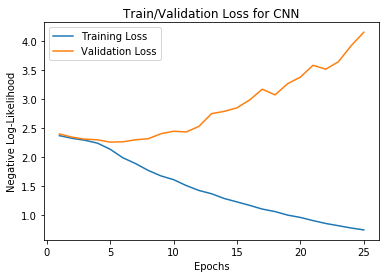

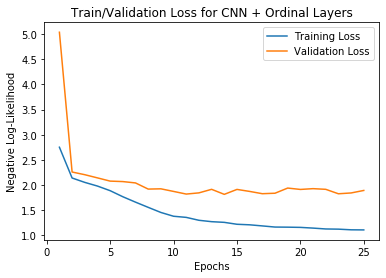

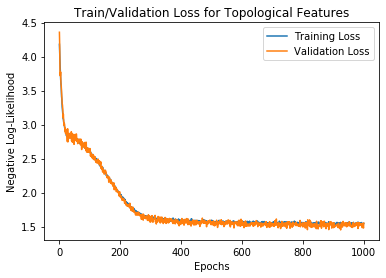

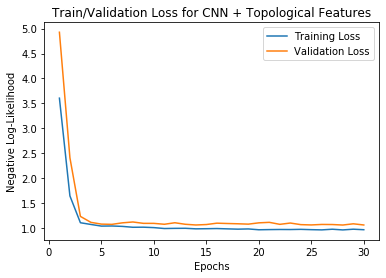

In [0]:
plot(categorical_losses, "Train/Validation Loss for CNN")
plot(ordinal_losses, "Train/Validation Loss for CNN + Ordinal Layers")
plot(topnet_losses, "Train/Validation Loss for Topological Features", length=1000)
plot(top_conv_losses, "Train/Validation Loss for CNN + Topological Features", length=30)

In [0]:
evaluate(conv_model, "ConvNet.pkl", image_test, nn.CrossEntropyLoss())
evaluate(ordinal_conv_model, "OrdinalConvNet_nontrainable_thresholds.pkl", image_test, nn.NLLLoss())
evaluate(top_model, "TopNet.pkl", top_test, nn.NLLLoss())
evaluate(top_conv_model, "TopConvNet.pkl", image_and_top_test, nn.NLLLoss())

Test Loss: 5.686664551496506 on final model
Accuracy: 0.1925 on final model
Test Loss: 2.3293142169713974 on best model
Accuracy: 0.1245 on best model
Test Loss: 1.8741531781852245 on final model
Accuracy: 0.2775 on final model
Test Loss: 1.9601176269352436 on best model
Accuracy: 0.269 on best model
Test Loss: 1.505206748843193 on final model
Accuracy: 0.3815 on final model
Test Loss: 1.5261287726461887 on best model
Accuracy: 0.372 on best model
Test Loss: 0.94579903408885 on final model
Accuracy: 0.1015 on final model
Test Loss: 0.9604617729783058 on best model
Accuracy: 0.1055 on best model
